# CC Ansatz mapping to qubit gates 

In [1]:
from qiskit_nature.second_q.circuit.library import UCC, HartreeFock
from qiskit_nature.second_q.mappers import JordanWignerMapper
import pyscf, pyscf.mcscf
from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.operators import ElectronicIntegrals

from qiskit.circuit import QuantumCircuit
import ffsim
from ffsim import qiskit as fqs
import numpy as np

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from ffsim import qiskit as fqs

from qiskit.circuit import QuantumCircuit
from ffsim import qiskit as fqs
import ffsim
import numpy as np

from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print([b.name for b in service.backends()[:5]])
backend = service.backend("ibm_torino")   

# shallow
#pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
#pm.pre_init = fqs.PRE_INIT

# deep
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
pm.pre_init = None

/home/david/.venvs/tikzplot/lib/python3.12/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


['ibm_brisbane', 'ibm_torino']


# Hydrogen 

STO-3G

In [6]:
# Build H2 molecule
mol = pyscf.gto.Mole()
mol.build(atom=[("H", (0.0,0.0,0.0)), ("H", (0.0,0.0, 0.741))], unit = "Angstrom", basis="sto-3g", verbose=0)

scf = pyscf.scf.RHF(mol)
scf.kernel()

# Get molecular integrals
active_space = list(range(mol.nao_nr()))
norb = len(active_space)
nelectron_cas = int(sum(scf.mo_occ[active_space]))
n_alpha = (nelectron_cas + mol.spin) // 2
n_beta = (nelectron_cas - mol.spin) // 2
nelec = (n_alpha, n_beta)
cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
mo_coeff = cas.sort_mo(active_space, base=0)
h1e_cas, ecore = cas.get_h1eff(mo_coeff=mo_coeff)
h2e_cas = cas.get_h2eff(mo_coeff=mo_coeff)

print("NORB:", norb, "NELEC", nelec)

n_spatial_orb = scf.mo_coeff.shape[1]
n_particles = (n_alpha, n_beta)
mapper = JordanWignerMapper()
hf = HartreeFock(num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper)
qc_uccsd = UCC(excitations="sd",num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper,initial_state=hf)

pm = generate_preset_pass_manager(optimization_level = 3, backend=backend)
pm.pre_init = fqs.PRE_INIT
qc_uccsd_native = pm.run(qc_uccsd) # send to native set via preset pass manager


print("\nuccsd transpiled stats:\n", qc_uccsd_native.count_ops(),
       "\n depth:", qc_uccsd_native.depth())

# load saved amplitudes
t1_pack = np.load("../data/amps/t1_h2_sto-3g_fullspace.npz")
t2_pack = np.load("../data/amps/t2_h2_sto-3g_fullspace.npz")
R_grid = t1_pack["R"]
t1_all = t1_pack["t1"]  # (nR, nocc, nvir)
t2_all = t2_pack["t2"]  # (nR, nocc, nocc, nvir, nvir)
nocc = int(t1_pack["nocc"])
nvir = int(t1_pack["nvir"])

i = 0
t1 = t1_all[i]               # (nocc, nvir)
t2 = t2_all[i]               # (nocc, nocc, nvir, nvir)

norb = nocc + nvir
nelec = (nocc, nocc)
num_qubits = 2 * norb

print("NORB:", norb, "NELEC", nelec)

# GLOBAL UCJ
ucj_global = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1)
qc_ucj = QuantumCircuit(num_qubits)
qc_ucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_ucj.qubits)
qc_ucj.append(fqs.UCJOpSpinBalancedJW(ucj_global), qc_ucj.qubits)

# LOCAL UCJ (nearest-neighbor same-spin + on-site opposite-spin)
pairs_aa = [(p, p+1) for p in range(norb - 1)]
pairs_ab = [(p, p)   for p in range(norb)]
lucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj = QuantumCircuit(num_qubits)
qc_lucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj.qubits)
qc_lucj.append(fqs.UCJOpSpinBalancedJW(lucj), qc_lucj.qubits)

# 2 fold lucj
lucj2 = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=2, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj2 = QuantumCircuit(num_qubits)
qc_lucj2.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj2.qubits)
qc_lucj2.append(fqs.UCJOpSpinBalancedJW(lucj2), qc_lucj2.qubits)


qc_ucj_hw  = pm.run(qc_ucj)
qc_lucj_hw = pm.run(qc_lucj)
qc_lucj2_hw = pm.run(qc_lucj2)


print("Global UCJ (hw) depth:", qc_ucj_hw.depth(), qc_ucj_hw.count_ops())
print("Local  UCJ (hw) depth:", qc_lucj_hw.depth(), qc_lucj_hw.count_ops())
print("Local  2-UCJ (hw) depth:", qc_lucj2_hw.depth(), qc_lucj2_hw.count_ops())



NORB: 2 NELEC (1, 1)

uccsd transpiled stats:
 OrderedDict({'rz': 94, 'sx': 83, 'cz': 49, 'x': 1}) 
 depth: 159
NORB: 2 NELEC (1, 1)
Global UCJ (hw) depth: 103 OrderedDict({'sx': 74, 'rz': 51, 'cz': 30})
Local  UCJ (hw) depth: 49 OrderedDict({'sx': 54, 'rz': 46, 'cz': 20})
Local  2-UCJ (hw) depth: 84 OrderedDict({'sx': 92, 'rz': 71, 'cz': 36})


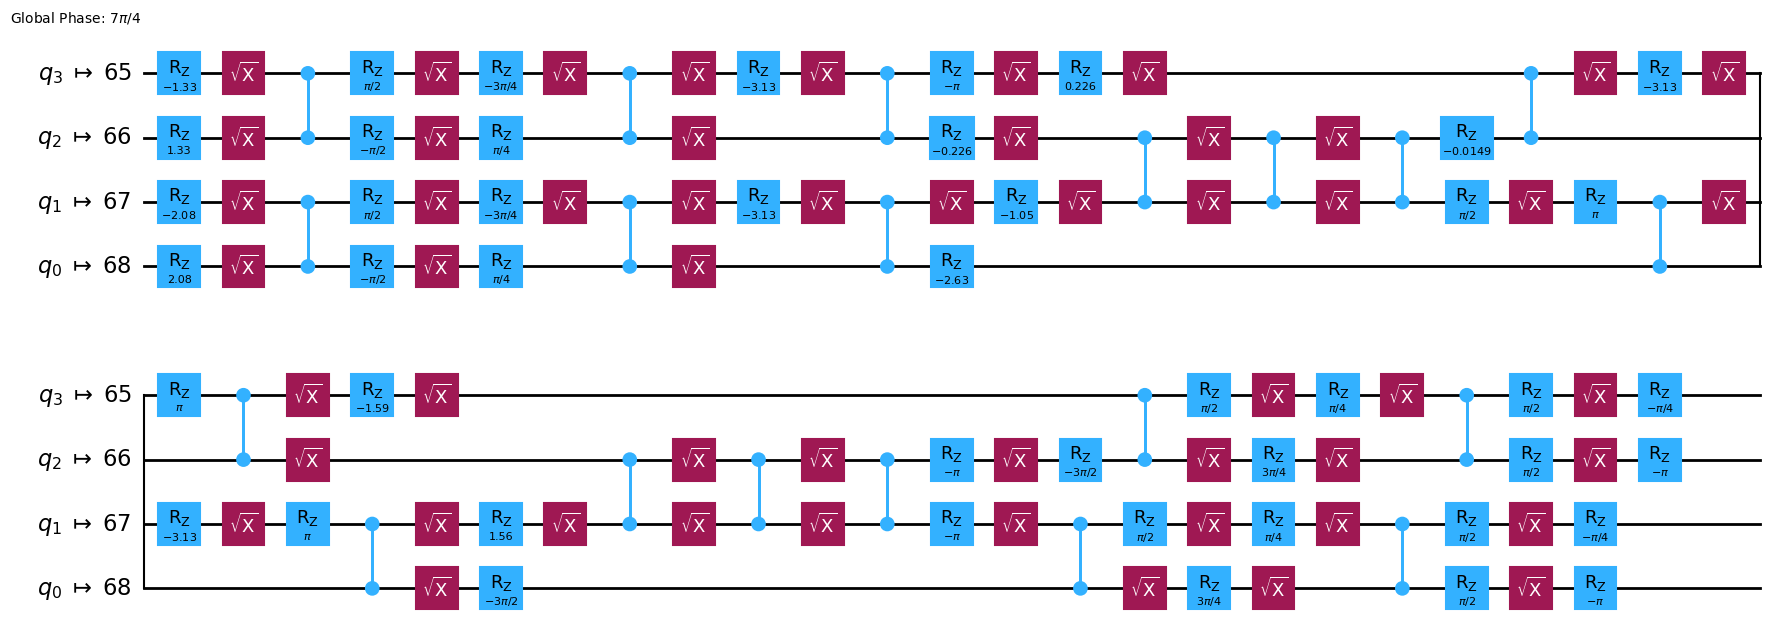

In [7]:
qc_lucj_hw.draw("mpl")

CC-pVDZ

In [8]:
# Build H2 molecule
mol = pyscf.gto.Mole()
mol.build(atom=[("H", (0.0,0.0,0.0)), ("H", (0.0,0.0, 0.741))], unit = "Angstrom", basis="cc-pvdz", verbose=0)

scf = pyscf.scf.RHF(mol)
scf.kernel()

# Get molecular integrals
active_space = list(range(mol.nao_nr()))
norb = len(active_space)
nelectron_cas = int(sum(scf.mo_occ[active_space]))
n_alpha = (nelectron_cas + mol.spin) // 2
n_beta = (nelectron_cas - mol.spin) // 2
nelec = (n_alpha, n_beta)
cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
mo_coeff = cas.sort_mo(active_space, base=0)
h1e_cas, ecore = cas.get_h1eff(mo_coeff=mo_coeff)
h2e_cas = cas.get_h2eff(mo_coeff=mo_coeff)

print(f"N molecular orbitals: {norb}, N electrons: {nelec}, N virtual orbitals: {nvir}, N occupied orbitals: {nocc}")

n_spatial_orb = scf.mo_coeff.shape[1]
n_particles = (n_alpha, n_beta)
mapper = JordanWignerMapper()
hf = HartreeFock(num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper)
qc_uccsd = UCC(excitations="sd",num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper,initial_state=hf)

pm = generate_preset_pass_manager(optimization_level = 3, backend=backend)
pm.pre_init = fqs.PRE_INIT
qc_uccsd_native = pm.run(qc_uccsd) # send to native set via preset pass manager


print("uCCSD transpiled depth:", qc_uccsd_native.depth(), qc_uccsd_native.count_ops())

# load saved amplitudes
t1_pack = np.load("../data/amps/t1_h2_cc-pVDZ_fullspace.npz")
t2_pack = np.load("../data/amps/t2_h2_cc-pVDZ_fullspace.npz")
R_grid = t1_pack["R"]
t1_all = t1_pack["t1"]  # (nR, nocc, nvir)
t2_all = t2_pack["t2"]  # (nR, nocc, nocc, nvir, nvir)
nocc = int(t1_pack["nocc"])
nvir = int(t1_pack["nvir"])

i = 0
t1 = t1_all[i]               # (nocc, nvir)
t2 = t2_all[i]               # (nocc, nocc, nvir, nvir)

norb = nocc + nvir
nelec = (nocc, nocc)
num_qubits = 2 * norb

print(f"\nN molecular orbitals: {norb}, N electrons: {nelec}, N virtual orbitals: {nvir}, N occupied orbitals: {nocc}")

# GLOBAL UCJ
ucj_global = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1)
qc_ucj = QuantumCircuit(num_qubits)
qc_ucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_ucj.qubits)
qc_ucj.append(fqs.UCJOpSpinBalancedJW(ucj_global), qc_ucj.qubits)

# LOCAL UCJ (nearest-neighbor same-spin + on-site opposite-spin)
pairs_aa = [(p, p+1) for p in range(norb - 1)]
pairs_ab = [(p, p)   for p in range(norb)]
lucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj = QuantumCircuit(num_qubits)
qc_lucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj.qubits)
qc_lucj.append(fqs.UCJOpSpinBalancedJW(lucj), qc_lucj.qubits)

# 2 fold lucj
lucj2 = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=2, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj2 = QuantumCircuit(num_qubits)
qc_lucj2.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj2.qubits)
qc_lucj2.append(fqs.UCJOpSpinBalancedJW(lucj2), qc_lucj2.qubits)

pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
pm.pre_init = None  

qc_ucj_hw  = pm.run(qc_ucj)
qc_lucj_hw = pm.run(qc_lucj)
qc_lucj2_hw = pm.run(qc_lucj2)

print("Global UCJ (hw) depth:", qc_ucj_hw.depth(), qc_ucj_hw.count_ops())
print("Local  UCJ (hw) depth:", qc_lucj_hw.depth(), qc_lucj_hw.count_ops())
print("Local  2-UCJ (hw) depth:", qc_lucj2_hw.depth(), qc_lucj2_hw.count_ops())

N molecular orbitals: 10, N electrons: (1, 1), N virtual orbitals: 1, N occupied orbitals: 1
uCCSD transpiled depth: 40935 OrderedDict({'sx': 17020, 'rz': 16427, 'cz': 13289, 'x': 484})

N molecular orbitals: 10, N electrons: (1, 1), N virtual orbitals: 9, N occupied orbitals: 1
Global UCJ (hw) depth: 322 OrderedDict({'sx': 480, 'rz': 370, 'cz': 254, 'x': 58})
Local  UCJ (hw) depth: 137 OrderedDict({'sx': 357, 'rz': 349, 'cz': 184, 'x': 47})
Local  2-UCJ (hw) depth: 204 OrderedDict({'sx': 627, 'rz': 626, 'cz': 348, 'x': 86})


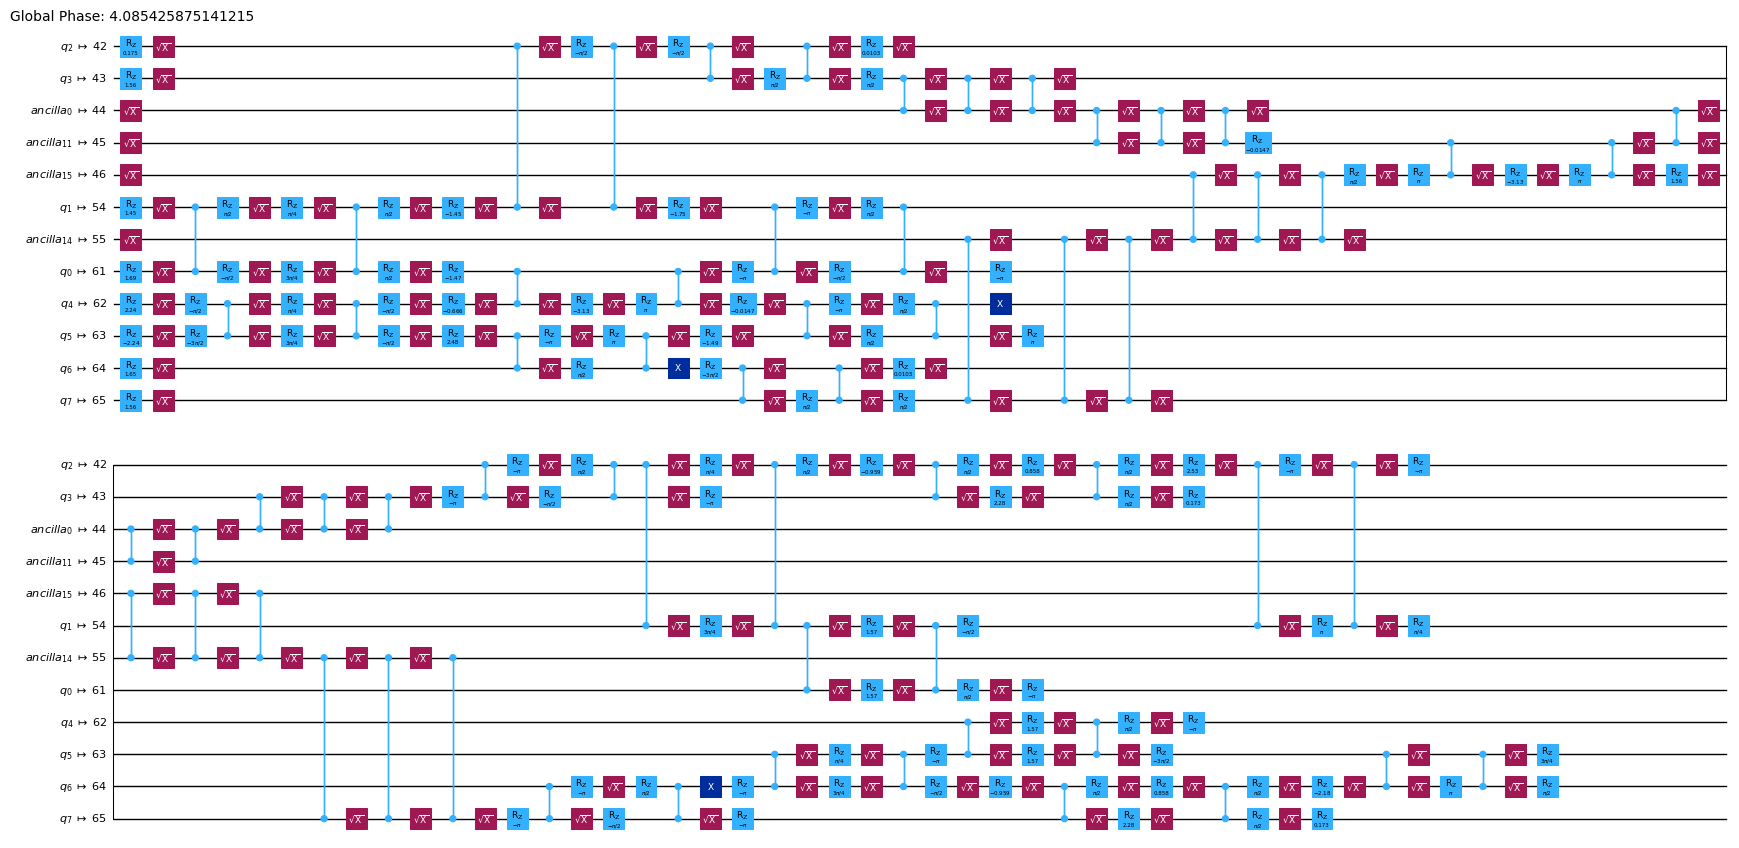

In [42]:
qc_lucj_hw.draw("mpl", fold = 50, scale=0.5)

In [ ]:
# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(atom=[("N", (-0.5*1.1,0.0,0.0)), ("N", (0.5*1.1,0.0,0.0))], unit = "Angstrom", basis="sto-3g", verbose=0)

scf = pyscf.scf.RHF(mol)
scf.kernel()

# Get molecular integrals
active_space = list(range(2, mol.nao_nr()))
norb = len(active_space)
nelectron_cas = int(sum(scf.mo_occ[active_space]))
n_alpha = (nelectron_cas + mol.spin) // 2
n_beta = (nelectron_cas - mol.spin) // 2
nelec = (n_alpha, n_beta)
cas = pyscf.mcscf.RCASCI(scf, ncas=norb, nelecas=nelec)
mo_coeff = cas.sort_mo(active_space, base=0)
h1e_cas, ecore = cas.get_h1eff(mo_coeff=mo_coeff)
h2e_cas = cas.get_h2eff(mo_coeff=mo_coeff)

print("NORB:", norb, "NELEC", nelec)

n_spatial_orb = scf.mo_coeff.shape[1]
n_particles = (n_alpha, n_beta)
mapper = JordanWignerMapper()
hf = HartreeFock(num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper)
qc_uccsd = UCC(excitations="sd",num_spatial_orbitals=n_spatial_orb,num_particles=n_particles,qubit_mapper=mapper,initial_state=hf)

pm = generate_preset_pass_manager(optimization_level = 3, backend=backend)
pm.pre_init = fqs.PRE_INIT
qc_uccsd_native = pm.run(qc_uccsd) # send to native set via preset pass manager


NORB: 10 NELEC (7, 7)

uccsd transpiled stats:
 OrderedDict({'sx': 155103, 'cz': 109993, 'rz': 102704, 'x': 3870}) 
 depth: 296734


In [48]:
print("Nitrogen: ")
print("Transpiled stats:\n", qc_uccsd_native.count_ops(), "Depth:", qc_uccsd_native.depth())
print("n_qubits:", qc_uccsd_native.num_qubits)

Nitrogen: 
Transpiled stats:
 OrderedDict({'sx': 155103, 'cz': 109993, 'rz': 102704, 'x': 3870}) Depth: 296734
n_qubits: 133


In [53]:
# load saved amplitudes
t1_pack = np.load("../data/amps/t1_n2_sto-3g.npz")
t2_pack = np.load("../data/amps/t2_n2_sto-3g.npz")
R_grid = t1_pack["R"]
t1_all = t1_pack["t1"]  # (nR, nocc, nvir)
t2_all = t2_pack["t2"]  # (nR, nocc, nocc, nvir, nvir)
nocc = int(t1_pack["nocc"])
nvir = int(t1_pack["nvir"])

i = 0
t1 = t1_all[i]               # (nocc, nvir)
t2 = t2_all[i]               # (nocc, nocc, nvir, nvir)

norb = nocc + nvir
nelec = (nocc, nocc)
num_qubits = 2 * norb

print(f"\nN molecular orbitals: {norb+2}, N electrons: {nelec}, N virtual orbitals: {nvir}, N occupied orbitals: {nocc}\n")

# GLOBAL UCJ
ucj_global = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1)
qc_ucj = QuantumCircuit(num_qubits)
qc_ucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_ucj.qubits)
qc_ucj.append(fqs.UCJOpSpinBalancedJW(ucj_global), qc_ucj.qubits)

# LOCAL UCJ (nearest-neighbor same-spin + on-site opposite-spin)
pairs_aa = [(p, p+1) for p in range(norb - 1)]
pairs_ab = [(p, p)   for p in range(norb)]
lucj = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=1, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj = QuantumCircuit(num_qubits)
qc_lucj.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj.qubits)
qc_lucj.append(fqs.UCJOpSpinBalancedJW(lucj), qc_lucj.qubits)

# 2 fold lucj
lucj2 = ffsim.UCJOpSpinBalanced.from_t_amplitudes(t2=t2, t1=t1, n_reps=2, interaction_pairs=(pairs_aa, pairs_ab),)
qc_lucj2 = QuantumCircuit(num_qubits)
qc_lucj2.append(fqs.PrepareHartreeFockJW(norb, nelec), qc_lucj2.qubits)
qc_lucj2.append(fqs.UCJOpSpinBalancedJW(lucj2), qc_lucj2.qubits)

#pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
#pm.pre_init = None  

#With optimization
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
pm.pre_init = fqs.PRE_INIT

qc_ucj_hw  = pm.run(qc_ucj)
qc_lucj_hw = pm.run(qc_lucj)
qc_lucj2_hw = pm.run(qc_lucj2)

print("Global UCJ (hw) depth:", qc_ucj_hw.depth(), qc_ucj_hw.count_ops())
print("Local  UCJ (hw) depth:", qc_lucj_hw.depth(), qc_lucj_hw.count_ops())
print("Local  2-UCJ (hw) depth:", qc_lucj2_hw.depth(), qc_lucj2_hw.count_ops())


N molecular orbitals: 10, N electrons: (5, 5), N virtual orbitals: 3, N occupied orbitals: 5

Global UCJ (hw) depth: 757 OrderedDict({'sx': 1370, 'rz': 726, 'cz': 649, 'x': 46})
Local  UCJ (hw) depth: 183 OrderedDict({'sx': 513, 'rz': 445, 'cz': 228, 'x': 34})
Local  2-UCJ (hw) depth: 328 OrderedDict({'sx': 867, 'rz': 681, 'cz': 420, 'x': 70})


In [54]:
print(qc_ucj_hw.num_qubits)

133
